# Recommender systems

## One of the most common uses of big data is to predict and suggest what users may want.  This allows Google to show you relevant ads or to suggest news in Google Now; Amazon to recommend relevant products; Netflix to recommend movies that you might like; or most recently, the famous **Weekly Dicovery** of Spotify.

## All these products are based on systems of recommendation: a information retrieval method to provide users with relevant, yet novel and diverse, information. 

## In this class we will use a pretty famous dataset based on movies ratings, 'MovieLens', to learn the basics of recommender systems. 

## Table of Contents (times are approximated)

1. [Getting and analysing some data (~1:30 h)](#data)
2. [Most popular movies (~30 min)](#popular)
3. [Metrics for recommender systems (~1.30h)](#metrics)
4. [Collaborative Filtering (~15 min)](#cf)  
   4.1 [Co-occurrence Matrix (~1.30h)](#copurchase)
   <br></br>
   4.2 [Memory-based CF (~1 h)](#memory-base)
   <br></br>
   4.3 [Model-based CF (~2 h)](#model-base)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os

<a id='data'></a>
## 1.1 Load data

We will use MovieLens dataset, which is one of the most common datasets used when implementing and testing recommender engines. This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies. 
* Each user has rated at least 20 movies. 
* Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens [website](https://movielens.org) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set.

You can download the dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k.zip).

Take a look at the readme file!!!

In [2]:
data_root = '/home/gonzalo/Repos/Master_Data_Science/WEEK-14_RECOMMENDATION_SYSTEMS/ml-100k/'
readme = os.path.join(data_root, "README")
!cat $readme

SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under th

In [3]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
datafile = os.path.join(data_root, "u.data")
data = pd.read_csv(datafile, sep='\t', names=columns)
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


*Pandas library is nothing alse than numpy under the hood (numpy with steroids, if you like). You can access the data (in matrix from) with he "values" attribute, e.g. data.values*

In [4]:
# access all rows, and first 3 columns 
data.values[:, :3]

array([[ 196,  242,    3],
       [ 186,  302,    3],
       [  22,  377,    1],
       ...,
       [ 276, 1090,    1],
       [  13,  225,    2],
       [  12,  203,    3]])

In [5]:
# access all collumns, and first 3 rows 
data.values[:3, :]

array([[      196,       242,         3, 881250949],
       [      186,       302,         3, 891717742],
       [       22,       377,         1, 878887116]])

In [6]:
# access first 10 rows
data.values[:10, :]
# This is equivalent to data.values[:10]

array([[      196,       242,         3, 881250949],
       [      186,       302,         3, 891717742],
       [       22,       377,         1, 878887116],
       [      244,        51,         2, 880606923],
       [      166,       346,         1, 886397596],
       [      298,       474,         4, 884182806],
       [      115,       265,         2, 881171488],
       [      253,       465,         5, 891628467],
       [      305,       451,         3, 886324817],
       [        6,        86,         3, 883603013]])

In [7]:
# access first column
data.values[:, 0]

array([196, 186,  22, ..., 276,  13,  12])

In [8]:
# The attribute shape provides the shape of the matrix
data.values.shape

(100000, 4)

In [9]:
# Note that if we return the first column, we get a vector (of 100000 components)
data.values[:,0].shape

(100000,)

In [10]:
# same with the first row (this time, we get a vector of 4 components)
data.values[0].shape

(4,)

In [11]:
# Number of users and items
n_users = data.user_id.unique().shape[0]
n_items = data.item_id.unique().shape[0]
print("There are %s users and %s items" %(n_users, n_items))

There are 943 users and 1682 items


## 1.2 A dictionary for movies and a search tool

In order to analyze the predicted recommendations, let's create a python dictonary that will allow us to translate any item id to the corresponding movie title. Also, let's write a small function that returns the ids of the movies containing some text.

The correspondance between titles and ids is stored in the u.item file

In [12]:
data_root = '/home/gonzalo/Repos/Master_Data_Science/WEEK-14_RECOMMENDATION_SYSTEMS/ml-100k/'
items_id_file = os.path.join(data_root, "u.item")
!head $items_id_file

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0
6|Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|01-Jan-1995||http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0
7|Twelve Monkeys (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|1|0|0|0
8|Babe (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Babe%20(1995)|0|0|0|0|1

*Simple reminder of dictionaries*

In [13]:
aux = {'hola': 'que haces?', 1: '237'}

In [14]:
# Access value of key='hola'
aux['hola']

'que haces?'

In [15]:
# create new key
aux['nuevo'] = 'soy nuevo'
aux

{'hola': 'que haces?', 1: '237', 'nuevo': 'soy nuevo'}

In [16]:
# Update value of existing key
aux['nuevo'] = 'ya no lo soy'
aux['nuevo']

'ya no lo soy'

In [17]:
# Create a dictionary for movie titles and ids
item_dict = {}
with io.open(items_id_file, 'rb') as f:
    for line in f.readlines():
        record = line.split(b'|')
        item_dict[int(record[0])] = str(record[1])
    
# We can use this dict to see the films a user has seen, for instance. 
for record in data.values[:20]:
    print("User {u} viewed '{m}' and gave a {r} rating".format(
        u=record[0], m=item_dict[record[1]], r=record[2]))    

User 196 viewed 'b'Kolya (1996)'' and gave a 3 rating
User 186 viewed 'b'L.A. Confidential (1997)'' and gave a 3 rating
User 22 viewed 'b'Heavyweights (1994)'' and gave a 1 rating
User 244 viewed 'b'Legends of the Fall (1994)'' and gave a 2 rating
User 166 viewed 'b'Jackie Brown (1997)'' and gave a 1 rating
User 298 viewed 'b'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'' and gave a 4 rating
User 115 viewed 'b'Hunt for Red October, The (1990)'' and gave a 2 rating
User 253 viewed 'b'Jungle Book, The (1994)'' and gave a 5 rating
User 305 viewed 'b'Grease (1978)'' and gave a 3 rating
User 6 viewed 'b'Remains of the Day, The (1993)'' and gave a 3 rating
User 62 viewed 'b'Men in Black (1997)'' and gave a 2 rating
User 286 viewed 'b"Romy and Michele's High School Reunion (1997)"' and gave a 5 rating
User 200 viewed 'b'Star Trek: First Contact (1996)'' and gave a 5 rating
User 210 viewed 'b'To Wong Foo, Thanks for Everything! Julie Newmar (1995)'' and gave a 3 

In [18]:
item_dict

{1: "b'Toy Story (1995)'",
 2: "b'GoldenEye (1995)'",
 3: "b'Four Rooms (1995)'",
 4: "b'Get Shorty (1995)'",
 5: "b'Copycat (1995)'",
 6: "b'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)'",
 7: "b'Twelve Monkeys (1995)'",
 8: "b'Babe (1995)'",
 9: "b'Dead Man Walking (1995)'",
 10: "b'Richard III (1995)'",
 11: "b'Seven (Se7en) (1995)'",
 12: "b'Usual Suspects, The (1995)'",
 13: "b'Mighty Aphrodite (1995)'",
 14: "b'Postino, Il (1994)'",
 15: 'b"Mr. Holland\'s Opus (1995)"',
 16: "b'French Twist (Gazon maudit) (1995)'",
 17: "b'From Dusk Till Dawn (1996)'",
 18: "b'White Balloon, The (1995)'",
 19: 'b"Antonia\'s Line (1995)"',
 20: "b'Angels and Insects (1995)'",
 21: "b'Muppet Treasure Island (1996)'",
 22: "b'Braveheart (1995)'",
 23: "b'Taxi Driver (1976)'",
 24: "b'Rumble in the Bronx (1995)'",
 25: "b'Birdcage, The (1996)'",
 26: "b'Brothers McMullen, The (1995)'",
 27: "b'Bad Boys (1995)'",
 28: "b'Apollo 13 (1995)'",
 29: "b'Batman Forever (1995)'",
 30: "b'Belle de jou

In [19]:
# Define a function that retrieves all the ids and titles for movies containing 'text' in its title
def returnItemId(text, ids):
    """
    :param text: string to be looked for in movies titles
    :param ids: dicttionary of {id:title}
    
    :return: a list of (id,title) if text found in titles, and an empty list otherwise.
    """
    # convert input text to lowercase
    text_ = text.lower()
    # find occurances
    search = [(k, v.lower().find(text_)) 
              for k,v in list(ids.items())]
    # equivalent code (easier, but less pythonic XDD ):
    # search = []
    # for k,v in list(ids.items()):
    #     occurrances = v.lower().find(text_)
    #     search.append((k, occurrances))
    
    # Get the IDs corresponding to the given text
    index = [k for k,v in search if v>-1]
    
    # Return a list with the id and the name
    out = []
    for i in index:
        out.append((i, ids[i]))
    # Same in one line:
    # out = [(i, ids[i]) for i in index] if len(index)>0 else []
    return out

In [20]:
returnItemId('but', item_dict)

[(240, "b'Beavis and Butt-head Do America (1996)'"),
 (435, "b'Butch Cassidy and the Sundance Kid (1969)'"),
 (580,
  "b'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)'"),
 (1401, "b'M. Butterfly (1993)'"),
 (1459, "b'Madame Butterfly (1995)'"),
 (1614, "b'Reluctant Debutante, The (1958)'"),
 (1621, "b'Butterfly Kiss (1995)'"),
 (1645, "b'Butcher Boy, The (1998)'"),
 (1650, "b'Butcher Boy, The (1998)'")]

## 1.3 Data consistency (always double check everything!!!)

In [21]:
# check whether titles are unique or not. They are not!!!
print(len(set(item_dict.keys())))
print(len(set(item_dict.values())))

1682
1664


### One work around: create another dict that consolidates ids with the same movie title

In [22]:
list(item_dict.items())

[(1, "b'Toy Story (1995)'"),
 (2, "b'GoldenEye (1995)'"),
 (3, "b'Four Rooms (1995)'"),
 (4, "b'Get Shorty (1995)'"),
 (5, "b'Copycat (1995)'"),
 (6, "b'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)'"),
 (7, "b'Twelve Monkeys (1995)'"),
 (8, "b'Babe (1995)'"),
 (9, "b'Dead Man Walking (1995)'"),
 (10, "b'Richard III (1995)'"),
 (11, "b'Seven (Se7en) (1995)'"),
 (12, "b'Usual Suspects, The (1995)'"),
 (13, "b'Mighty Aphrodite (1995)'"),
 (14, "b'Postino, Il (1994)'"),
 (15, 'b"Mr. Holland\'s Opus (1995)"'),
 (16, "b'French Twist (Gazon maudit) (1995)'"),
 (17, "b'From Dusk Till Dawn (1996)'"),
 (18, "b'White Balloon, The (1995)'"),
 (19, 'b"Antonia\'s Line (1995)"'),
 (20, "b'Angels and Insects (1995)'"),
 (21, "b'Muppet Treasure Island (1996)'"),
 (22, "b'Braveheart (1995)'"),
 (23, "b'Taxi Driver (1976)'"),
 (24, "b'Rumble in the Bronx (1995)'"),
 (25, "b'Birdcage, The (1996)'"),
 (26, "b'Brothers McMullen, The (1995)'"),
 (27, "b'Bad Boys (1995)'"),
 (28, "b'Apollo 13 (1995)'"

In [23]:
duplicates_item_dict = {}
# Las claves en "duplicates_item_dict" son los nombres de las películas
# Los valores son una lista de los ids (que pueden ser uno solo, o varios)
for id,name in list(item_dict.items()):
    if name not in duplicates_item_dict:
        duplicates_item_dict[name] = [id]
    else:
        duplicates_item_dict[name] = duplicates_item_dict[name]+[id]

# show the duplicated titles
for k,v in list(duplicates_item_dict.items()):
    if len(v)>1:
        print(k,v)

b'Chasing Amy (1997)' [246, 268]
b'Kull the Conqueror (1997)' [266, 680]
b"Ulee's Gold (1997)" [297, 303]
b'Fly Away Home (1996)' [304, 500]
b'Ice Storm, The (1997)' [305, 865]
b'Deceiver (1997)' [309, 1606]
b'Desperate Measures (1998)' [329, 348]
b'Body Snatchers (1993)' [573, 670]
b'Substance of Fire, The (1996)' [711, 1658]
b'Money Talks (1997)' [876, 881]
b'That Darn Cat! (1997)' [878, 1003]
b'Hugo Pool (1997)' [1175, 1617]
b'Chairman of the Board (1998)' [1234, 1654]
b'Designated Mourner, The (1997)' [1256, 1257]
b'Hurricane Streets (1998)' [1395, 1607]
b'Sliding Doors (1998)' [1429, 1680]
b'Nightwatch (1997)' [1477, 1625]
b'Butcher Boy, The (1998)' [1645, 1650]


Create a dict where the key are the original ids, and the values are the unique one. 
We will use this dictionary to remove duplicates in a dataframe.

In [24]:
unique_id_item_dict ={}
for index, lista_id in enumerate(duplicates_item_dict.values()) :
    for key in lista_id:
        unique_id_item_dict[key] = index

Create another dict mapping moving titles to this new unique id

In [25]:
unique_item_dict = {unique_id_item_dict[k]:v 
                    for k,v in item_dict.items()}
assert(len(set(unique_item_dict.keys())) == 
       len(set(unique_item_dict.values())))

Now we can use our `returnItemId()` mehtod safely =)

In [26]:
returnItemId('but', unique_item_dict)

[(239, "b'Beavis and Butt-head Do America (1996)'"),
 (431, "b'Butch Cassidy and the Sundance Kid (1969)'"),
 (575,
  "b'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)'"),
 (1390, "b'M. Butterfly (1993)'"),
 (1448, "b'Madame Butterfly (1995)'"),
 (1601, "b'Reluctant Debutante, The (1958)'"),
 (1607, "b'Butterfly Kiss (1995)'"),
 (1630, "b'Butcher Boy, The (1998)'")]

In [27]:
returnItemId('but', item_dict)

[(240, "b'Beavis and Butt-head Do America (1996)'"),
 (435, "b'Butch Cassidy and the Sundance Kid (1969)'"),
 (580,
  "b'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)'"),
 (1401, "b'M. Butterfly (1993)'"),
 (1459, "b'Madame Butterfly (1995)'"),
 (1614, "b'Reluctant Debutante, The (1958)'"),
 (1621, "b'Butterfly Kiss (1995)'"),
 (1645, "b'Butcher Boy, The (1998)'"),
 (1650, "b'Butcher Boy, The (1998)'")]

## 1.4 Train and test sets

GroupLens provides several splits of the dataset, so that we can check the goodness of our algorithms. See the README file for more  details. Here we will use one of such splits.

Please notice that we have to correct for the non-unique movie's id issue!!

In [28]:
!ls $data_root

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [29]:
trainfile = os.path.join(data_root, 'ua.base')
!head $trainfile

1	1	5	874965758
1	2	3	876893171
1	3	4	878542960
1	4	3	876893119
1	5	3	889751712
1	6	5	887431973
1	7	4	875071561
1	8	1	875072484
1	9	5	878543541
1	10	3	875693118


In [30]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
trainfile = os.path.join(data_root, "ua.base")
train = pd.read_csv(trainfile, sep='\t', names=columns)
print('There are %s users, %s itmes and %s pairs in the train set' \
      %(train.user_id.unique().shape[0], train.item_id.unique().shape[0], train.shape[0]))
train.head()


There are 943 users, 1680 itmes and 90570 pairs in the train set


,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [31]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
testfile = os.path.join(data_root, "ua.test")
test = pd.read_csv(testfile, sep='\t', names=columns)
print('There are %s users, %s itmes and %s pairs in the test set' \
      %(test.user_id.unique().shape[0], test.item_id.unique().shape[0], test.shape[0]))
test.head()


There are 943 users, 1129 itmes and 9430 pairs in the test set


,user_id,item_id,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201


### Correcting for non-unique movies id 

*Reminder of lambda functions in Python: is a way of calling short functions (1 line of code), without having to define the function in a separted cell.*

In [32]:
def func(x):
    return unique_id_item_dict[x]

In [33]:
# These three  lines of code are equivalent!!
test['item_id'].apply(lambda z: func(z)).head() # we could use any name instead of 'z'
test['item_id'].apply(lambda z: unique_id_item_dict[z]).head() # we can directly implement the function 'func'
test['item_id'].apply(func).head() # Since 'func' has only 1 parameter, we can call it without calling the lambda expression

0     19
1     32
2     60
3    116
4    154
Name: item_id, dtype: int64

In [34]:
train['item_id'] = train['item_id'].apply(
    lambda pepito: unique_id_item_dict[pepito])
print('Now there are %s unique items in traint set' 
      % train.item_id.unique().shape[0])

Now there are 1662 unique items in traint set


In [35]:
test['item_id'] = test['item_id'].apply(func)
print('Now there are %s unique items in test set' 
      % test.item_id.unique().shape[0])

Now there are 1119 unique items in test set


<a id='popular'></a>
## 2. Most popular movies

Recommending popular items is a simple, yet quite effective baseline for recommendation. Indeed, most RS suffer from a strong *popularity bias*, i.e. they tend to recommend popular items more frequently than they should -just because suggesting what is popular is effective!-. There is a lot of research  devote to understand this behaviour and to develop recipies to avoid it. 

Movies can be ranked according to different popularity metrics:
* Most rated movie (it is assumed that this is the most watched movie)
* Most positively rated movie (rating > 4.0)
* Highest rated movie

## 2.1 Most rated movie

In [36]:
# group the train dataset by item and count the number of users using Pandas
mostRated = train.groupby('item_id')['user_id'].count()

In [37]:
mostRated.head()

item_id
0    392
1    121
2     85
3    198
4     79
Name: user_id, dtype: int64

In [38]:
# sort in descending order
mostRatedSorted = mostRated.sort_values(ascending=False)

In [39]:
mostRatedSorted.head()

item_id
49     495
99     443
180    439
257    412
284    400
Name: user_id, dtype: int64

In [40]:
mostRatedSorted.shape[0]

1662

In [41]:
mostRatedSorted.index

Int64Index([  49,   99,  180,  257,  284,  292,    0,  286,  120,  173,
            ...
            1560, 1563, 1570, 1564, 1565, 1566, 1341, 1568, 1569, 1663],
           dtype='int64', name='item_id', length=1662)

In [42]:
# Return a numpy array of [id, title, frequency]

# numpy requires knowledge of the data types. Since we have ids (integers) and titles (strings), 
# we will use a "parent" data type, np.object
mostRatedMovies = np.zeros(shape=(mostRatedSorted.shape[0], 3), dtype=np.object)

for i, index in enumerate(mostRatedSorted.index):
    id_ = index # id of the movie
    freq_ = mostRatedSorted[id_] # frequency of the movie
    title_ = unique_item_dict[id_]
    mostRatedMovies[i] = [id_, title_, freq_]
    
mostRatedMovies[:10,1:]

array([["b'Star Wars (1977)'", 495],
       ["b'Fargo (1996)'", 443],
       ["b'Return of the Jedi (1983)'", 439],
       ["b'Contact (1997)'", 412],
       ["b'English Patient, The (1996)'", 400],
       ["b'Liar Liar (1997)'", 398],
       ["b'Toy Story (1995)'", 392],
       ["b'Scream (1996)'", 386],
       ["b'Independence Day (ID4) (1996)'", 384],
       ["b'Raiders of the Lost Ark (1981)'", 379]], dtype=object)

## 2.2 Most positively rated movie

In [43]:
# filter movies rated with rating >=4.0. Then group by item, count the number of users and sort in descending order.
positiveRated = train[train.rating>=4.0].groupby('item_id')['user_id'].count().sort_values(ascending=False)

In [44]:
# Return a numpy array of [id, title, frequency]

# numpy requires knowledge of the data types. Since we have ids (integers) and titles (strings), 
# we will use a "parent" data type, np.object
positiveRatedMovies = np.zeros(shape=(positiveRated.shape[0], 3), dtype=np.object)

for i, index in enumerate(positiveRated.index):
    id_ = index # id of the movie
    freq_ = positiveRated[id_] # frequency of the movie
    title_ = unique_item_dict[id_]
    positiveRatedMovies[i] = [id_, title_, freq_]
    
positiveRatedMovies[:10,1:]

array([["b'Star Wars (1977)'", 428],
       ["b'Fargo (1996)'", 354],
       ["b'Return of the Jedi (1983)'", 331],
       ["b'Raiders of the Lost Ark (1981)'", 316],
       ["b'Silence of the Lambs, The (1991)'", 310],
       ["b'Godfather, The (1972)'", 298],
       ["b'Contact (1997)'", 276],
       ["b'Toy Story (1995)'", 275],
       ["b'Empire Strikes Back, The (1980)'", 264],
       ["b'Pulp Fiction (1994)'", 262]], dtype=object)

## 2.3 Highest mean rating movie

In [45]:
# obtaine the highest rated movies, with a minium number of users/ratings.
min_ratings = 50

# group the ratings by item and stack them in a list
listRatedMovies = train.groupby('item_id')['rating'].apply(list).reset_index()

# filter movies with a minimum number of ratings
filteredListRatedMovies = listRatedMovies[listRatedMovies.rating.apply(lambda x: len(x)>min_ratings)]

In [46]:
filteredListRatedMovies.head()

,item_id,rating
0,0,"[5, 4, 4, 4, 3, 1, 5, 5, 3, 5, 5, 5, 3, 5, 4, ..."
1,1,"[3, 3, 2, 3, 5, 1, 3, 3, 4, 4, 3, 2, 2, 3, 4, ..."
2,2,"[4, 2, 3, 4, 3, 2, 2, 1, 3, 3, 5, 3, 3, 3, 2, ..."
3,3,"[3, 5, 4, 5, 5, 5, 3, 5, 4, 2, 4, 4, 3, 3, 2, ..."
4,4,"[3, 1, 2, 3, 4, 4, 4, 3, 3, 2, 4, 3, 3, 4, 3, ..."


In [47]:
# obtain the mean of the list of rating per movie
meanMovies = filteredListRatedMovies.rating.apply(lambda x: np.mean(np.array(x))).sort_values(ascending=False)

In [48]:
# Return a numpy array of [id, title, frequency]

# numpy requires knowledge of the data types. Since we have ids (integers) and titles (strings), 
# we will use a "parent" data type, np.object
meanRateMovies = np.zeros(shape=(meanMovies.shape[0], 3), dtype=np.object)

for i, index in enumerate(meanMovies.index):
    id_ = index # id of the movie
    freq_ = meanMovies[id_] # frequency of the movie
    title_ = unique_item_dict[id_]
    meanRateMovies[i] = [id_, title_, freq_]
    
meanRateMovies[:10,1:]

array([["b'Wallace & Gromit: The Best of Aardman Animation (1996)'",
        4.491525423728813],
       ["b'Close Shave, A (1995)'", 4.480769230769231],
       ["b'Wrong Trousers, The (1993)'", 4.4766355140186915],
       ['b"Schindler\'s List (1993)"', 4.4758364312267656],
       ["b'Casablanca (1942)'", 4.459821428571429],
       ["b'Shawshank Redemption, The (1994)'", 4.457364341085271],
       ["b'Usual Suspects, The (1995)'", 4.386454183266932],
       ["b'Rear Window (1954)'", 4.374358974358974],
       ["b'Star Wars (1977)'", 4.365656565656566],
       ["b'12 Angry Men (1957)'", 4.327433628318584]], dtype=object)

<div class  = "alert alert-info"> 
** QUESTION **: set the value of *min_ratings* to 1, and re-run the cell. What happens now? Change this value
</div>

<div class  = "alert alert-info"> 
** QUESTION **: Which method is better?? How to measure a recommender system? 
</div>

<div class  = "alert alert-info"> 
** IMPORTANT QUESTION **: When might be useful to recommend popular items?
</div>

<a id='metrics'></a>
## 3. Metrics for recommender systems

As we have seen, even with the simplest solution --aka, recommending popular items-- is difficult to known which technique performs better. For this, there are a number of metrics that allow one to measure the goodness of a recommender system. 

Metrics can be design for measuring the relevance or accuracy of a recommendation, but they can be created for evaluating the novelty of a recommendation, or its diversity. 

For now, we will focus on relevance and accuracy. Several metrics exist:
* Accuracy: rmse, mae.
* Not ranked: Recall@k, Precision@k.
* With rank disccount: map@k, ndcg@k.
* With rank ordering: mean percentile rank.

We will be definiing some of them whitin this class. For the moment, let's talk about precision and recall.

## 3.1 Precision and recall

<img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" alt="Precision and Recall in IR" style="float: right; width: 300px"/>

The concept of precision and recall comes form the world of information retrieval, have a look at the wikipedia:

https://en.wikipedia.org/wiki/Precision_and_recall

From this entry:

 * "**precision** (also called positive predictive value) is the fraction of retrieved instances that are relevant".
 * "**recall** (also known as sensitivity) is the fraction of relevant instances that are retrieved".

<br />
<div class  = "alert alert-info"> 
** QUESTION **: how do we know if some movie, unknown to the user, is relevant?
</div>

In other words, we cannot measure a false positive --something recommended that was not relevant--. In this regard, only recall-oriented metrics have an actual meaning in RS. Nonetheless, its common practice to define both metrics in RS as follows:
 
### $$\mathrm{recall}@N = \frac{\sum_{k=1}^N rel(k)}{\sum_{i\in \mathcal{I}_u} 1}$$
### $$\mathrm{precision}@N = \frac{\sum_{k=1}^N rel(k)}{N}$$

Here, $\mathcal{I}_u$ is the set of items adopted by user $u$, and $rel(k)$ is the relevance of a recommendation at position k in the list of recommendations. For ratings, the relevance could be defined as those movies rated above a certain threshold, e.g. $r_{ui}>4.0$. 

**Important to note: since precision is pretty much the same as recall in RS, metrcis usch as the *area under the ROC curve* doesn't have any meaning!!**

<div class = "alert alert-success">
As an example, consider a user that watched the following films:
<br /><br />
'Designated Mourner, The (1997)'
<br />
'Money Talks (1997)'
<br />
'Madame Butterfly (1995)'
<br />
'Batman Forever (1995)'
<br /><br />
The recommended items were: 
<br /><br />
'Batman (1989)' 
<br />
'Madame Butterfly (1995)'
<br /><br />
**What would be the recall and precision @1? and @2?**
<br />
**What do you think of recommending Batman? Is a bad or a good recommendation?**
</div>

Please notice that there isn't any actual difference between precision and recall in the context of RS: both measure the relevance of the recommendations, and tell nothing about items recommended that haven't been adopted by the user. Thus, it make sense to define a normalized recall as:

### $$\mathrm{recall}@N = \frac{\sum_{i=1}^N rel_i}{\mathrm{min}(N, \sum_{i\in \mathcal{I}_u} 1})$$

This way, results are normalized to 1 always.

<div class="alert alert-success">
**Exercise** Implement the above definition of recall
</div>

In [49]:
def recall_at_n(N, test, recommended, train=None):
    """
    :param N: number of recommendations
    :param test: list of movies seen by user in test
    :param train: list of movies seen by user in train. This has to be removed from the recommended list 
    :param recommended: list of movies recommended
    
    :return the recall
    """
    if train is not None: # Remove items in train
        # Esta línea de abajo estaría mal!!! por qué? Respuesta: al usar "set", perdemos el orden en la recomendación
        # rec_true =  set(recommended)- set(train)
        
        # Correct implementation
        rec_true = []
        for r in recommended:
            if r not in train:
                rec_true.append(r)
        # Equivalent 1-line of code:
        # rec_true = [r for r in recommended if r not in train]
    else:
        rec_true = recommended    
    intersection = len(set(test) & set(rec_true[:N]))
    return intersection / float(np.minimum(N, len(test)))

In [50]:
seen = ['Designated Mourner, The (1997)', 'Money Talks (1997)', 'Madame Butterfly (1995)', 'Batman Forever (1995)']
recommended = ['Batman (1989)', 'Madame Butterfly (1995)']

In [51]:
recall_at_n(1, seen, recommended)

0.0

In [52]:
recall_at_n(2, seen, recommended)

0.5

In [53]:
# Check it's well normalized
print(recall_at_n(3, seen, recommended))
print(recall_at_n(10, seen, recommended))
print(recall_at_n(100, seen, recommended))

0.3333333333333333
0.25
0.25


### Now, use this implementation to measure the efficiency of the popularity baselines in the test set. Use the top-5 movies, for instance

In [54]:
mostRatedMovies[:5,1:]

array([["b'Star Wars (1977)'", 495],
       ["b'Fargo (1996)'", 443],
       ["b'Return of the Jedi (1983)'", 439],
       ["b'Contact (1997)'", 412],
       ["b'English Patient, The (1996)'", 400]], dtype=object)

In [55]:
positiveRatedMovies[:5,1:]

array([["b'Star Wars (1977)'", 428],
       ["b'Fargo (1996)'", 354],
       ["b'Return of the Jedi (1983)'", 331],
       ["b'Raiders of the Lost Ark (1981)'", 316],
       ["b'Silence of the Lambs, The (1991)'", 310]], dtype=object)

In [56]:
meanRateMovies[:5,1:]

array([["b'Wallace & Gromit: The Best of Aardman Animation (1996)'",
        4.491525423728813],
       ["b'Close Shave, A (1995)'", 4.480769230769231],
       ["b'Wrong Trousers, The (1993)'", 4.4766355140186915],
       ['b"Schindler\'s List (1993)"', 4.4758364312267656],
       ["b'Casablanca (1942)'", 4.459821428571429]], dtype=object)

In [57]:
train.head()

,user_id,item_id,rating,timestamp
0,1,0,5,874965758
1,1,1,3,876893171
2,1,2,4,878542960
3,1,3,3,876893119
4,1,4,3,889751712


*Since `recall_at_n` takes both train and test list per user, we need to create a dataset with the list of movies seen in train and test*

Thus, get the list of movies per user in train and test, and join the two dataframes. For the join, use the pandas method `merge`.

In [58]:
# get movies in train per user. For this, group by user and get a list of item ids.
trainUsersGrouped = (train[train.rating>=4.0]
                    .groupby('user_id')['item_id']
                    .apply(list).reset_index()
                   )

In [59]:
# same with test data
testUsersGrouped = (test[test.rating>=4.0]
                    .groupby('user_id')['item_id']
                    .apply(list).reset_index()
                   )

In [60]:
# make the join
joined = pd.merge(trainUsersGrouped, testUsersGrouped, how='inner', on='user_id', suffixes=('_train', '_test'))

In [61]:
joined.head()

,user_id,item_id_train,item_id_test
0,1,"[0, 2, 5, 6, 8, 11, 12, 13, 14, 15, 17, 18, 21...","[19, 32, 60, 159, 170, 201, 264]"
1,2,"[0, 13, 24, 99, 110, 126, 236, 241, 254, 256, ...","[12, 49, 250, 290, 295]"
2,3,"[180, 259, 315, 317, 318, 324, 326, 337, 339, ...","[325, 328]"
3,4,"[10, 257, 269, 298, 299, 321, 324, 326, 355, 3...","[49, 259, 286, 292, 295, 350, 353, 357]"
4,5,"[23, 28, 39, 41, 49, 61, 69, 88, 94, 99, 100, ...","[0, 16]"


In [62]:
joined.item_id_test.head()

0           [19, 32, 60, 159, 170, 201, 264]
1                    [12, 49, 250, 290, 295]
2                                 [325, 328]
3    [49, 259, 286, 292, 295, 350, 353, 357]
4                                    [0, 16]
Name: item_id_test, dtype: object

In [63]:
# We can also access test values as follows:
joined.apply(lambda x: x[2], axis=1).head()

0           [19, 32, 60, 159, 170, 201, 264]
1                    [12, 49, 250, 290, 295]
2                                 [325, 328]
3    [49, 259, 286, 292, 295, 350, 353, 357]
4                                    [0, 16]
dtype: object

In [64]:
# This second method is easier if we want to access several columns at once, and operate over them.
# For instance, if we like to concatenate both train and test list, we will do:
joined.apply(lambda x: x[1]+x[2], axis=1).head()

0    [0, 2, 5, 6, 8, 11, 12, 13, 14, 15, 17, 18, 21...
1    [0, 13, 24, 99, 110, 126, 236, 241, 254, 256, ...
2    [180, 259, 315, 317, 318, 324, 326, 337, 339, ...
3    [10, 257, 269, 298, 299, 321, 324, 326, 355, 3...
4    [23, 28, 39, 41, 49, 61, 69, 88, 94, 99, 100, ...
dtype: object

In [65]:
# calculate the recall of the mostRatedMovies recommendation, for each user:
joined.apply(lambda l: 
             recall_at_n(N=15, test=l[2], recommended=mostRatedMovies[:, 0], train=l[1]), axis=1).head()

0    0.142857
1    0.200000
2    0.000000
3    0.375000
4    0.500000
dtype: float64

*As you can see, some users have a quite large recall (0.5), while for others is small (e.g, 0.14). Let's calculate the mean.*

In [66]:
topN = 30
# calculate the average recall across all users
recall_per_user = joined.apply(lambda l: 
             recall_at_n(N=topN, test=l[2], recommended=mostRatedMovies[:, 0], train=l[1]), axis=1)
recall_per_user.mean()

0.23399655008327386

In [67]:
recall_per_user = joined.apply(lambda l: 
             recall_at_n(N=topN, test=l[2], recommended=positiveRatedMovies[:, 0], train=l[1]), axis=1)
recall_per_user.mean()

0.23440569661126404

In [68]:
recall_per_user = joined.apply(lambda l: 
             recall_at_n(topN, l[2], meanRateMovies[:, 0], l[1]), axis=1)
recall_per_user.mean()

0.13298239352843205

## 3.2 Mean Averaged Precision (MAP) -- Advanced material

Previous metrics did not account for the ranking of the recommendation, i.e. the relative position of a movie within the sorted list of recommendations. **But orders matters!** Metrics like MAP, MRR or NDCG try to tackle down this problem. 

From the blog *http://fastml.com/what-you-wanted-to-know-about-mean-average-precision/*:

> Here’s another way to understand average precision. Wikipedia says AP is used to score document retrieval. You can think of it this way: you type something in Google and it shows you 10 results. It’s probably best if all of them were relevant. If only some are relevant, say five of them, then it’s much better if the relevant ones are shown first. It would be bad if first five were irrelevant and good ones only started from sixth, wouldn’t it? AP score reflects this.

Implementation taken from:

https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py



## Average Precision 

The Average Precision is definied as:

### $$\mathrm{AP}@N = \frac{\sum_{k=1}^N P(k) \times rel(k)}{\mathrm{min}(N, \sum_{i\in \mathcal{I}_u} 1)}$$

where $P(k)$ is the precision at cut-off in the item list, i.e. the ratio of the number of recommended items adopted, up to the position k, over the number k. Thus:

### $$\mathrm{AP}@N = \frac{\sum_{k=1}^N \left(\sum_{i=1}^k rel(i)\right)/k \times rel(k)}{\mathrm{min}(N, \sum_{i\in \mathcal{I}_u} 1)}$$



<div class = "alert alert-success">
Following the example above, consider a user that watched the following films:
<br /><br />
'Designated Mourner, The (1997)'
<br />
'Money Talks (1997)'
<br />
'Madame Butterfly (1995)'
<br />
'Batman Forever (1995)'
<br /><br />
The recommended items were: 
<br /><br />
'Batman (1989)' 
<br />
'Madame Butterfly (1995)'
<br /><br />

<div class = "alert alert-success">
**Calculate AP@1**
<br /><br />
First, *rel(1)=0*, because Batman was not viewed. Also, *P(1) = 0*. Thus, AP@1=0.
<br />
**Calculate AP@2**
<br /><br />
As before, *rel(1)=0*, so the first term does not contribute. For the second term, *rel(2)=1*, so that *P(2)=0.5*. The numerator is hence:
<br /><br />
$P(1)*rel(1)+P(2)*rel(2)=0*0+0.5*1$
<br /><br />
For the denominator, $N=2$ and $\sum_{i\in \mathcal{I}_u} 1)=4$, thus:
<br /><br />
AP@2 = 0.5/2 = 0.25
</div>

Let's now implement it =)

In [69]:
def apk(N, test, recommended, train=None):
    """
    Computes the average precision at N given recommendations.
    
    :param N: number of recommendations
    :param test: list of movies seen by user in test
    :param train: list of movies seen by user in train. This has to be removed from the recommended list 
    :param recommended: list of movies recommended
    
    :return The average precision at N over the test set
    """
    if train is not None: 
        rec_true = []
        for r in recommended:
            if r not in train:
                rec_true.append(r)
    else:
        rec_true = recommended    
    predicted = rec_true[:N] # top-k predictions
    
    score = 0.0 # This will store the numerator
    num_hits = 0.0 # This will store the sum of rel(i)

    for i,p in enumerate(predicted):
        if p in test and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits/(i+1.0)

    return score / min(len(test), N)

In [70]:
seen = ['Designated Mourner, The (1997)', 'Money Talks (1997)', 'Madame Butterfly (1995)', 'Batman Forever (1995)']
recommended = ['Madame Butterfly (1995)', 'Batman (1989)']

In [71]:
apk(1, seen, recommended)

1.0

In [72]:
apk(2, seen, recommended)

0.5

In [73]:
apk(3, seen, recommended)

0.3333333333333333

## MAP

Mean avergae precision is nothing else than the AP averaged across users ;)

Apply it to popularity baselines

In [74]:
topN = 1
predictions = mostRatedMovies[:, 0]
m1 = joined.apply(lambda l: 
             apk(topN, l[2], predictions, l[1]), axis=1).mean()
print("map@%s=%.2f" % (topN, m1))
topN = 10
m2 = joined.apply(lambda l: 
             apk(topN, l[2], predictions, l[1]), axis=1).mean()
print("map@%s=%.2f" % (topN, m2))

map@1=0.13
map@10=0.05


In [75]:
topN = 1
predictions = positiveRatedMovies[:, 0]
m1 = joined.apply(lambda l: 
             apk(topN, l[2], predictions, l[1]), axis=1).mean()
print("map@%s=%.2f" % (topN, m1))
topN = 10
m2 = joined.apply(lambda l: 
             apk(topN, l[2], predictions, l[1]), axis=1).mean()
print("map@%s=%.2f" % (topN, m2))

map@1=0.13
map@10=0.05


In [76]:
topN = 1
predictions = meanRateMovies[:, 0]
m1 = joined.apply(lambda l: 
             apk(topN, l[2], predictions, l[1]), axis=1).mean()
print("map@%s=%.2f" % (topN, m1))
topN = 10
m2 = joined.apply(lambda l: 
             apk(topN, l[2], predictions, l[1]), axis=1).mean()
print("map@%s=%.2f" % (topN, m2))

map@1=0.01
map@10=0.01


<img src="https://courses.edx.org/c4x/BerkeleyX/CS100.1x/asset/Collaborative_filtering.gif" alt="collaborative filtering" style="float: right; width: 300px"/>

## 4. Collaborative Filtering <a id='cf'></a>

Perhaps, one of the most succesful techniques for making personalized recommendations are the so called *collaborative filtering* (CF) algorithms. CF is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue X than to have the opinion on X of a person chosen randomly. 

The image at the right (from Wikipedia) shows an example of user's preference prediction using collaborative filtering. At first, people rate different items (like videos, images, games). After that, the system is making predictions about a user's rating for an item, which the user has not rated yet. These predictions are built upon the existing ratings of other users, who have similar ratings with the active user. For instance, in the image at the right the system has made a prediction, that the active user will not like the video.

In this part we will see three kinds of CF, of increasing complexity:

4.1 [CF with co-occurrence](#copurchase)

4.2 [Memory-based CF](#memory-base)

4.3 [Model-based CF](#model-base)

In [80]:
#Matriz de concurrencia
moviesPerUser = (train[train.rating>=4]
                .groupby('user_id')['item_id']
                .apply(np.array)
                .to_dict())

In [82]:
type(moviesPerUser)

dict

In [78]:
n_items = len(unique_id_item_dict.keys())

In [83]:
coMatrix = np.zeros((n_items, n_items))

for user, movies in moviesPerUser.items():
    for m in movies:
        coMatrix[m, movies] += 1    

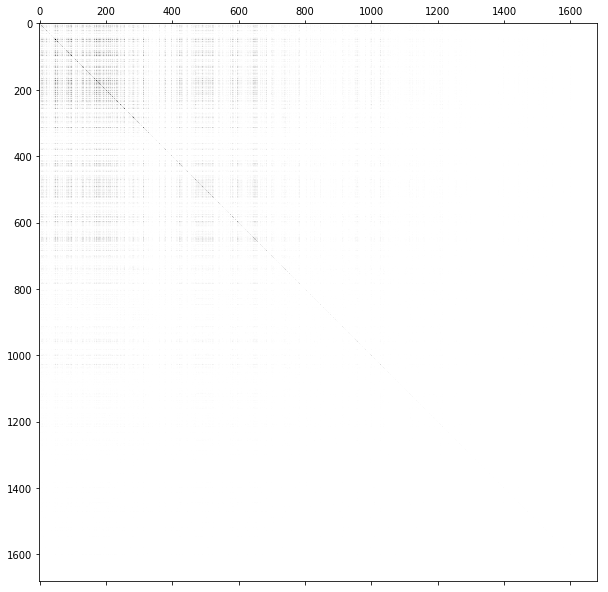

In [88]:
plt.matshow(coMatrix, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(10,10)

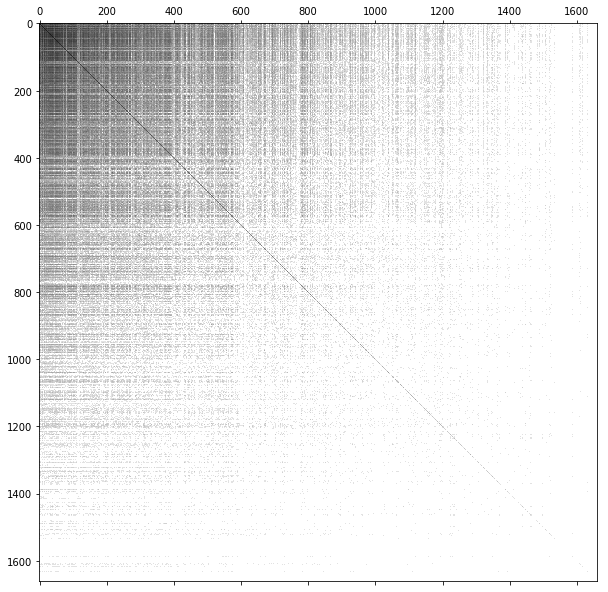

In [89]:
popular_indexing = mostRatedMovies[:,0].astype(np.int)
coMatrix_sorted = coMatrix[:, popular_indexing]
coMatrix_sorted_total = coMatrix_sorted[popular_indexing,:]
log_scale = np.log(coMatrix_sorted_total + 1.0)
plt.matshow(log_scale, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(10,10)

In [93]:
def co_occurrance_similarity(item_id, coocurrance, n_top=10):
    similarItems = coocurrance[item_id, :]
    mostSimilar = np.argsort(similarItems)[::-1]
    mostSimilar = mostSimilar[1:n_top+1]
    
    return np.stack((mostSimilar, similarItems[mostSimilar])).T

In [95]:
co_occurrance_similarity(49, coMatrix, 5)

array([[180., 276.],
       [173., 240.],
       [171., 224.],
       [ 97., 218.],
       [ 99., 205.]])

In [98]:
queryMovieId = 180
Ntop = 5
print('For item %s top-%s recommendations are: ' % (unique_item_dict[queryMovieId], Ntop))

similarItems = co_occurrance_similarity(queryMovieId, coMatrix, Ntop)

for r in similarItems:
    print(unique_item_dict[int(r[0])], r[1])

For item b'Return of the Jedi (1983)' top-5 recommendations are: 
b'Star Wars (1977)' 276.0
b'Empire Strikes Back, The (1980)' 192.0
b'Raiders of the Lost Ark (1981)' 192.0
b'Silence of the Lambs, The (1991)' 167.0
b'Fargo (1996)' 163.0


In [102]:
def co_occurrance_recommendation(items_id, coocurrance, ntop=10):
    list_sim_items = \
    list_1 = []
    for id_ in items_id:
        list_1.append(co_occurrance_similarity(id_, coocurrance, ntop))
    list_sim_items = np.vstack(list_1)
    
    largest_freq = pd.DataFrame(list_sim_items, columns=['id', 'freq']).groupby('id').agg(max).reset_index()
    
    sorted_list = largest_freq.sort_values(by='freq', ascending=False)

    out = sorted_list.values[:ntop, 0]
    return out

In [100]:
trainUsersGrouped = train[train.rating>=4.0].groupby('user_id')['item_id'].apply(list).reset_index()
trainUsersGrouped.head()

,user_id,item_id
0,1,"[0, 2, 5, 6, 8, 11, 12, 13, 14, 15, 17, 18, 21..."
1,2,"[0, 13, 24, 99, 110, 126, 236, 241, 254, 256, ..."
2,3,"[180, 259, 315, 317, 318, 324, 326, 337, 339, ..."
3,4,"[10, 257, 269, 298, 299, 321, 324, 326, 355, 3..."
4,5,"[23, 28, 39, 41, 49, 61, 69, 88, 94, 99, 100, ..."


In [103]:
Ntop = 5
predictions = trainUsersGrouped.item_id.apply(lambda x: co_occurrance_recommendation(x, coMatrix, Ntop))

In [104]:
predictions.head()

0    [49.0, 180.0, 173.0, 171.0, 97.0]
1     [49.0, 126.0, 99.0, 97.0, 180.0]
2     [49.0, 171.0, 173.0, 97.0, 99.0]
3     [49.0, 180.0, 99.0, 97.0, 173.0]
4    [180.0, 49.0, 173.0, 171.0, 97.0]
Name: item_id, dtype: object

In [106]:
topN = 30
trainUsersGrouped['predictons'] = trainUsersGrouped.item_id.apply(lambda x: co_occurrance_recommendation(x, coMatrix, topN))

In [107]:
trainUsersGrouped.head()

,user_id,item_id,predictons
0,1,"[0, 2, 5, 6, 8, 11, 12, 13, 14, 15, 17, 18, 21...","[180.0, 49.0, 173.0, 171.0, 97.0, 99.0, 126.0,..."
1,2,"[0, 13, 24, 99, 110, 126, 236, 241, 254, 256, ...","[49.0, 126.0, 99.0, 97.0, 180.0, 173.0, 55.0, ..."
2,3,"[180, 259, 315, 317, 318, 324, 326, 337, 339, ...","[49.0, 171.0, 173.0, 97.0, 99.0, 0.0, 126.0, 2..."
3,4,"[10, 257, 269, 298, 299, 321, 324, 326, 355, 3...","[49.0, 180.0, 99.0, 97.0, 173.0, 55.0, 6.0, 12..."
4,5,"[23, 28, 39, 41, 49, 61, 69, 88, 94, 99, 100, ...","[180.0, 49.0, 173.0, 171.0, 97.0, 99.0, 126.0,..."


In [108]:
joined = pd.merge(trainUsersGrouped, testUsersGrouped,
                 how='inner', on='user_id',
                 suffixes=('_train','_test'))

In [109]:
joined.head()

,user_id,item_id_train,predictons,item_id_test
0,1,"[0, 2, 5, 6, 8, 11, 12, 13, 14, 15, 17, 18, 21...","[180.0, 49.0, 173.0, 171.0, 97.0, 99.0, 126.0,...","[19, 32, 60, 159, 170, 201, 264]"
1,2,"[0, 13, 24, 99, 110, 126, 236, 241, 254, 256, ...","[49.0, 126.0, 99.0, 97.0, 180.0, 173.0, 55.0, ...","[12, 49, 250, 290, 295]"
2,3,"[180, 259, 315, 317, 318, 324, 326, 337, 339, ...","[49.0, 171.0, 173.0, 97.0, 99.0, 0.0, 126.0, 2...","[325, 328]"
3,4,"[10, 257, 269, 298, 299, 321, 324, 326, 355, 3...","[49.0, 180.0, 99.0, 97.0, 173.0, 55.0, 6.0, 12...","[49, 259, 286, 292, 295, 350, 353, 357]"
4,5,"[23, 28, 39, 41, 49, 61, 69, 88, 94, 99, 100, ...","[180.0, 49.0, 173.0, 171.0, 97.0, 99.0, 126.0,...","[0, 16]"


In [111]:
recall = joined.apply(lambda l: recall_at_n(N=topN, test=l[3], recommended=l[2], train=l[1]), axis=1).mean()
print('recall@%s=%.3f' % (topN, recall))

recall@30=0.190


In [ ]:
def evaluate_map(topN, trainGrouped, testGrouped, testGrouped, coMatrix, popularity_baseline):
    trainUsersGrouped['prediction'] = trainUsersGrouped.item_id.apply(
    lambda x: co_occurrance_recommendation(x, coMatrix, topN))
    
    joined = pd.merge(trainUsersGrouped, testUsersGrouped,
                     how='inner', on='user_id',
                     suffixes=('_train', '_test'))
    
    map_ = joined.apply(lambda l: apk(n=topN, test=l[3], recommended=l[2]))

# Model based

In [113]:
print(n_users)
print(n_items)

943
1682


In [114]:
uMatrixTraining = np.zeros((n_users, n_items))
for row in train.values[:,:3]:
    uMatrixTraining[row[0] - 1, row[1]] = row[2]

In [116]:
uMatrixTraining[0,:]

array([5., 3., 4., ..., 0., 0., 0.])

In [117]:
def cosineSimilarity(ratings, kind='user', epsilon=1e-9):
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

In [118]:
cosineSimilarity(uMatrixTraining, 'item')

array([[1.00000000e+00, 4.02959259e-01, 3.33261366e-01, ...,
        4.01642056e-07, 4.01642056e-07, 4.01642056e-07],
       [4.02959259e-01, 1.00000000e+00, 2.69185099e-01, ...,
        8.59708265e-07, 8.59708265e-07, 8.59708265e-07],
       [3.33261366e-01, 2.69185099e-01, 1.00000000e+00, ...,
        1.04370715e-06, 1.04370715e-06, 1.04370715e-06],
       ...,
       [4.01642056e-07, 8.59708265e-07, 1.04370715e-06, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.01642056e-07, 8.59708265e-07, 1.04370715e-06, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.01642056e-07, 8.59708265e-07, 1.04370715e-06, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [119]:
userSimilarity = cosineSimilarity(uMatrixTraining, 'user')

In [120]:
norm = np.array([userSimilarity.sum(axis=1)]).T
userItemCFpredictions = userSimilarity.dot(uMatrixTraining) / norm

In [121]:
#item-item
itemSimilarity = cosineSimilarity(uMatrixTraining, kind='item')
itemItemCFpredictions = uMatrixTraining.dot(itemSimilarity) / np.array([np.abs(itemSimilarity).sum(axis=1)])

In [122]:
itemItemCFpredictions.shape

(943, 1682)